# Jupyter notebook based on ImageD11 to process scanning 3DXRD data
# Written by Haixing Fang, Jon Wright and James Ball
## Date: 20/02/2024

In [11]:
# There is a bug with the current version of ImageD11 in the site-wide Jupyter env.
# This has been fixed here: https://github.com/FABLE-3DXRD/ImageD11/commit/4af88b886b1775585e868f2339a0eb975401468f
# Until a new release has been made and added to the env, we need to get the latest version of ImageD11 from GitHub
# Put it in your home directory
# USER: Change the path below to point to your local copy of ImageD11:

import os

username = os.environ.get("USER")

id11_code_path = f"/home/esrf/{username}/Code/ImageD11"

import sys

sys.path.insert(0, id11_code_path)

In [12]:
# import functions we need

import os
import concurrent.futures
import timeit

import matplotlib
%matplotlib widget

import h5py
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt


import ImageD11.columnfile
from ImageD11.sinograms import properties, roi_iradon
from ImageD11.blobcorrector import eiger_spatial
from ImageD11.grain import grain
from ImageD11 import cImageD11

import utils

In [13]:
# OLD DATASETS

# NOTE: For old datasets before the new directory layout structure, we don't distinguish between RAW_DATA and PROCESSED_DATA
# In this case, use this cell to specify where your experimental folder is, and do not run the cell below
# e.g /data/visitor/4752/id11/20210513

### USER: specify your experimental directory

rawdata_path = "/home/esrf/james1997a/Data/ma4752/id11/20210618"

!ls -lrt {rawdata_path}

### USER: specify where you want your processed data to go

processed_data_root_dir = "/home/esrf/james1997a/Data/ma4752/id11/20240118/James"

total 5249
-rwxr-x---  1 backup backup 5372439 Jun 25  2021 ma4752_id11.h5
drwxr-x--- 25 backup backup    4096 Jan 18 06:08 MA4752_S4_2_XRD


In [14]:
# USER: pick a sample and a dataset you want to segment

sample = "MA4752_S4_2_XRD"
dataset = "DTL1z90"

In [15]:
# desination of H5 files

dset_path = os.path.join(processed_data_root_dir, sample, f"{sample}_{dataset}", f"{sample}_{dataset}_dataset.h5")

par_path = 'nickel.par'

e2dx_path = "/data/id11/nanoscope/Eiger/spatial_20210415_JW/e2dx.edf"
e2dy_path = "/data/id11/nanoscope/Eiger/spatial_20210415_JW/e2dy.edf"

In [16]:
# Load the dataset (for motor positions, not sure why these are not in peaks)
ds = ImageD11.sinograms.dataset.load(dset_path)

In [17]:
def read_grains(ds):
    with h5py.File(ds.grainsfile, 'r') as hin:
        grp = hin['slice_recon']
        
        raw_intensity_array = grp['intensity'][:]
        grain_labels_array = grp['labels'][:]
       
        grains_group = 'grains'
        
        grains = []
        for gid_string in tqdm(sorted(hin[grains_group].keys(), key=lambda x: int(x))):
            gg = hin[grains_group][gid_string]
            ubi = gg.attrs['ubi'][:]
            g = ImageD11.grain.grain(ubi)
            # general grain properties
            g.gid = int(gid_string)
            g.translation = gg['translation'][:]
            g.cen = gg.attrs['cen']
            # sinogram stuff
            g.ssino = gg['ssino'][:]
            g.sinoangles = gg['sinoangles'][:]
            # reconstructions
            g.og_recon = gg['og_recon'][:]
            g.recon = gg['recon'][:]
            grains.append(g)
    
    return grains, raw_intensity_array, grain_labels_array


def read_carbide_grains(ds):
    ds.grainsfile_carbides = os.path.join(ds.analysispath, ds.dsname + '_grains_carbides.h5')
    with h5py.File(ds.grainsfile_carbides, 'r') as hin:
        grp = hin['slice_recon']
        
        raw_intensity_array = grp['intensity'][:]
        grain_labels_array = grp['labels'][:]
       
        grains_group = 'grains'
        
        grains = []
        for gid_string in tqdm(sorted(hin[grains_group].keys(), key=lambda x: int(x))):
            gg = hin[grains_group][gid_string]
            ubi = gg.attrs['ubi'][:]
            g = ImageD11.grain.grain(ubi)
            # general grain properties
            g.gid = int(gid_string)
            g.translation = gg['translation'][:]
            g.cen = gg.attrs['cen']
            # sinogram stuff
            g.ssino = gg['ssino'][:]
            g.sinoangles = gg['sinoangles'][:]
            # reconstructions
            g.og_recon = gg['og_recon'][:]
            g.recon = gg['recon'][:]
            grains.append(g)
    
    return grains, raw_intensity_array, grain_labels_array

In [18]:
grains_Ni, raw_intensity_array_Ni, grain_labels_array_Ni = read_grains(ds)
grains_C, raw_intensity_array_C, grain_labels_array_C = read_carbide_grains(ds)

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

In [19]:
for grain in tqdm(grains_Ni):
    grain.rgb_z = utils.grain_to_rgb(grain, ax=(0,0,1),)# symmetry = Symmetry.cubic)
    grain.rgb_y = utils.grain_to_rgb(grain, ax=(0,1,0),)# symmetry = Symmetry.cubic)
    grain.rgb_x = utils.grain_to_rgb(grain, ax=(1,0,0),)# symmetry = Symmetry.cubic)
    
for grain in tqdm(grains_C):
    grain.rgb_z = utils.grain_to_rgb(grain, ax=(0,0,1),)# symmetry = Symmetry.cubic)
    grain.rgb_y = utils.grain_to_rgb(grain, ax=(0,1,0),)# symmetry = Symmetry.cubic)
    grain.rgb_x = utils.grain_to_rgb(grain, ax=(1,0,0),)# symmetry = Symmetry.cubic)

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

In [96]:
red_Ni = np.zeros_like(grains_Ni[0].recon)
grn_Ni = np.zeros_like(grains_Ni[0].recon)
blu_Ni = np.zeros_like(grains_Ni[0].recon)

for g in tqdm(grains_Ni):
    red_Ni[grain_labels_array_Ni == g.gid] = g.rgb_z[0]
    grn_Ni[grain_labels_array_Ni == g.gid] = g.rgb_z[1]
    blu_Ni[grain_labels_array_Ni == g.gid] = g.rgb_z[2]
    
rgb_Ni = np.transpose((red_Ni, grn_Ni, blu_Ni), axes=(1, 2, 0))

red_C = np.zeros_like(grains_C[0].recon)
grn_C = np.zeros_like(grains_C[0].recon)
blu_C = np.zeros_like(grains_C[0].recon)

for g in tqdm(grains_C):
    red_C[grain_labels_array_C == g.gid] = g.rgb_z[0]
    grn_C[grain_labels_array_C == g.gid] = g.rgb_z[1]
    blu_C[grain_labels_array_C == g.gid] = g.rgb_z[2]
    
rgb_C = np.transpose((red_C, grn_C, blu_C), axes=(1, 2, 0))

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

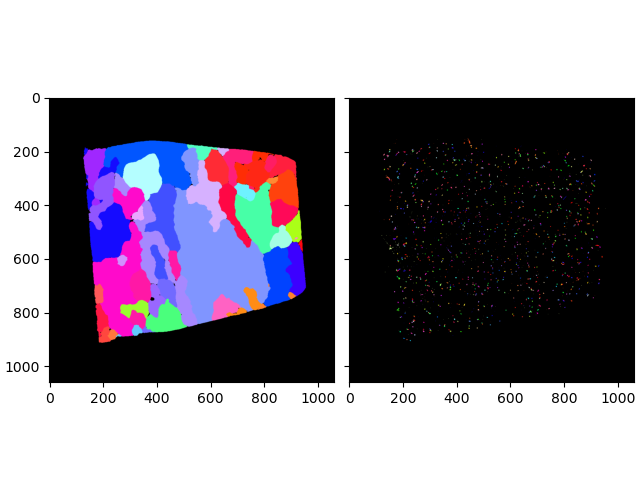

In [25]:
fig, axs = plt.subplots(1, 2, constrained_layout=True, sharex=True, sharey=True)
axs[0].imshow(rgb_Ni)
axs[1].imshow(rgb_C)
plt.show()

In [77]:
rgb_C_alpha = np.append(rgb_C, np.zeros((rgb_C.shape[0], rgb_C.shape[1], 1)), axis=2)

In [80]:
rgb_C_alpha[rgb_C_alpha[:, :, 0] != 0, 3] = 1

In [95]:
(raw_intensity_array_C != 0).astype(float)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

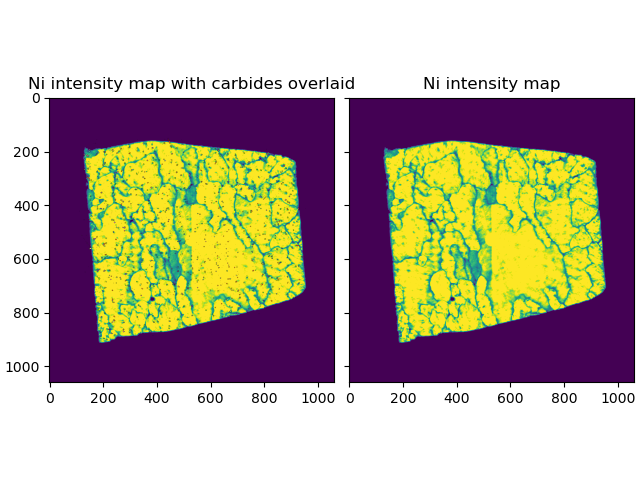

In [99]:
fig, axs = plt.subplots(1, 2, constrained_layout=True, sharex=True, sharey=True)
axs[0].imshow(raw_intensity_array_Ni, cmap="viridis")
axs[0].imshow(rgb_C_alpha)
axs[1].imshow(raw_intensity_array_Ni, cmap="viridis")
axs[0].set_title("Ni intensity map with carbides overlaid")
axs[1].set_title("Ni intensity map")
plt.show()

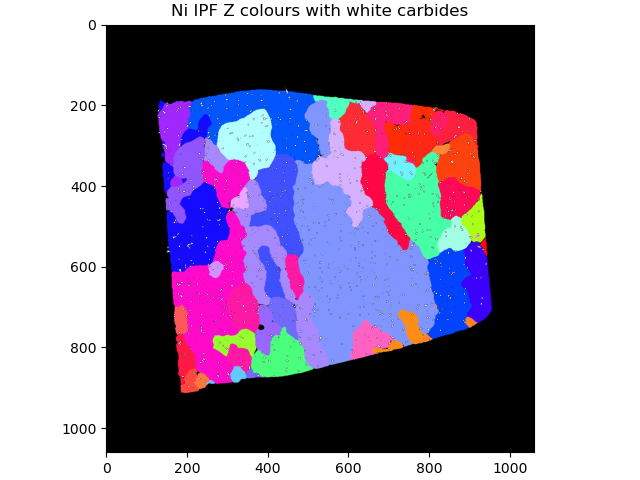

In [100]:
fig, ax = plt.subplots(constrained_layout=True, sharex=True, sharey=True)
ax.imshow(rgb_Ni)
ax.imshow(raw_intensity_array_C, alpha=(raw_intensity_array_C != 0).astype(float), cmap="grey")
ax.set_title("Ni IPF Z colours with white carbides")
plt.show()

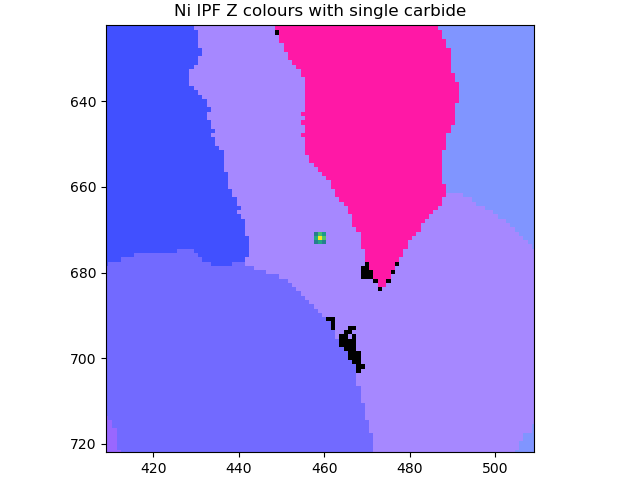

In [144]:
# orientation relationship stuff

# pick a carbide grain

carbide_grain = grains_C[500]

# find out where it is in the sample

fig, ax = plt.subplots(constrained_layout=True, sharex=True, sharey=True)
ax.imshow(rgb_Ni)
ax.imshow(carbide_grain.recon, alpha=(carbide_grain.recon > 0.05).astype(float))
ax.set_title("Ni IPF Z colours with single carbide")

vr = 50

ax.set_xlim(carbide_grain.translation[0]-vr, carbide_grain.translation[0]+vr)
ax.set_ylim(carbide_grain.translation[1]+vr, carbide_grain.translation[1]-vr)
plt.show()

In [141]:
# find Ni grain surrounding carbide grain

carbide_grain_pos_nearest_px = carbide_grain.translation.copy()
carbide_grain_pos_nearest_px = np.round(carbide_grain_pos_nearest_px).astype(int)

print(carbide_grain_pos_nearest_px)

Ni_grain_gid = grain_labels_array_Ni[carbide_grain_pos_nearest_px[1], carbide_grain_pos_nearest_px[0]].astype(int)

print(Ni_grain_gid)

[459 672   0]
3


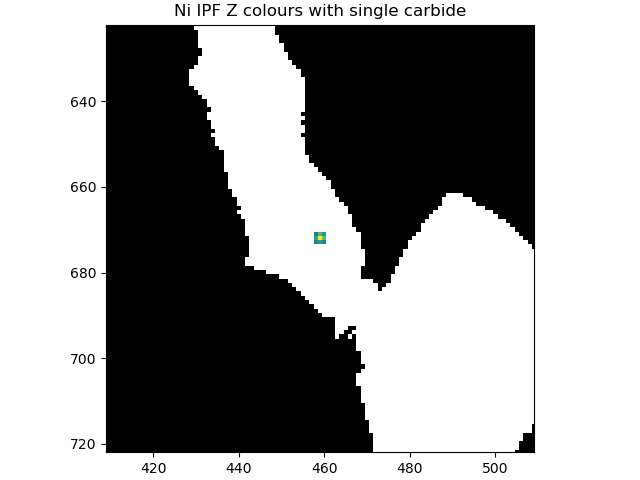

In [146]:
# confirm Ni grain selection

# rgb_Ni_masked = rgb_

fig, ax = plt.subplots(constrained_layout=True, sharex=True, sharey=True)
ax.imshow(grain_labels_array_Ni == Ni_grain_gid, cmap="grey")
ax.imshow(carbide_grain.recon, alpha=(carbide_grain.recon > 0.05).astype(float))
ax.set_title("Ni IPF Z colours with single carbide")

vr = 50

ax.set_xlim(carbide_grain.translation[0]-vr, carbide_grain.translation[0]+vr)
ax.set_ylim(carbide_grain.translation[1]+vr, carbide_grain.translation[1]-vr)
plt.show()

In [148]:
# we now have a carbide grain and the nickel grain that it's inside

# look for orientation relationships

nickel_grain = [grain for grain in grains_Ni if grain.gid == Ni_grain_gid][0]

print(nickel_grain.U)
print(carbide_grain.U)

[[-0.46626813 -0.27268832  0.84156705]
 [ 0.44149841 -0.89609513 -0.04574566]
 [ 0.76659845  0.35022077  0.53821206]]
[[-0.58490055 -0.71442363 -0.38404456]
 [-0.28887367  0.62591782 -0.72441624]
 [ 0.75792041 -0.31277109 -0.57247785]]


In [ ]:
# https://doi.org/10.1016/S1005-0302(12)60169-8
# we are looking for MC carbides
# 4 different types of OR present
# A {001} carbide // {001} matrix , <100> carbide // <100> matrix
# B [001] carbide // [310] matrix , (020) carbide // (1-31) matrix
# C [110] carbide // [310] matrix , (-11-1) carbide // (002) matrix
# D [001] carbide // [001] matrix , (-260) carbide // (020) matrix

# let's check A

In [160]:
from xfab.parameters import read_par_file

par_file_ni = './nickel.par'
par_file_c = './carbide.par'

pars_ni = read_par_file(par_file_ni)
pars_c = read_par_file(par_file_c)

In [161]:
ucell_ni = [pars_ni.get("cell__a"), pars_ni.get("cell__b"), pars_ni.get("cell__c"), pars_ni.get("cell_alpha"), pars_ni.get("cell_beta"), pars_ni.get("cell_gamma")]
ucell_c = [pars_c.get("cell__a"), pars_c.get("cell__b"), pars_c.get("cell__c"), pars_c.get("cell_alpha"), pars_c.get("cell_beta"), pars_c.get("cell_gamma")]

In [502]:
ucell_c

[4.3857, 4.3857, 4.3857, 90.0, 90.0, 90.0]

In [170]:

from diffpy.structure import Lattice, Structure
from orix.crystal_map import Phase
from orix.quaternion import Orientation, Rotation, symmetry
from orix.vector import Miller, Vector3d

struc_Ni = Structure(lattice=Lattice(*ucell_ni))
struc_C = Structure(lattice=Lattice(*ucell_c))

cubic_Ni = Phase(point_group="m-3m", structure=struc_Ni)
cubic_C = Phase(point_group="m-3m", structure=struc_C)

# crystal frame:

matrix_plane = Miller(hkl=[0, 0, 1], phase=cubic_Ni)
carbide_plane = Miller(hkl=[0, 0, 1], phase=cubic_C)

matrix_dir = Miller(uvw=[1, 0, 0], phase=cubic_Ni)
carbide_dir = Miller(hkl=[1, 0, 0], phase=cubic_C)

# orientations in Orix are sample-to-crystal, so we have to invert
o_Ni = Orientation.from_matrix(nickel_grain.U.T)
o_C = Orientation.from_matrix(carbide_grain.U.T)

matrix_plane_lab = ~o_Ni * matrix_plane.symmetrise(unique=True)
carbide_plane_lab = ~o_C * carbide_plane.symmetrise(unique=True)

matrix_dir_lab = ~o_Ni * matrix_dir.symmetrise(unique=True)
carbide_dir_lab = ~o_C * carbide_dir.symmetrise(unique=True)

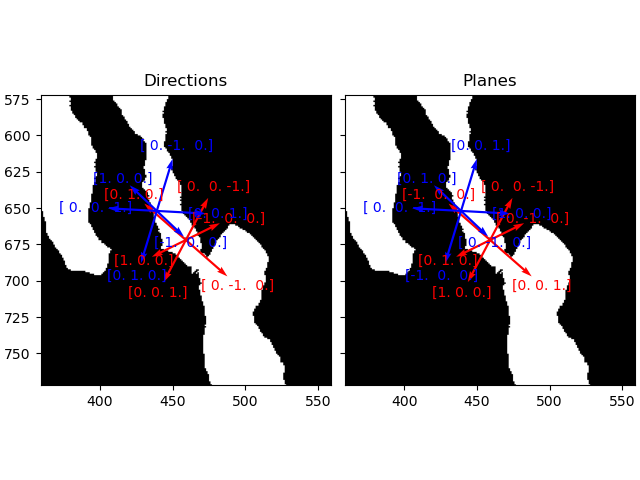

In [552]:
fig, axs = plt.subplots(1, 2, constrained_layout=True, sharex=True, sharey=True)

axs[0].imshow(grain_labels_array_Ni == Ni_grain_gid, cmap="grey")
axs[0].imshow(carbide_grain.recon, alpha=(carbide_grain.recon > 0.05).astype(float))
axs[0].set_title("Directions")

axs[1].imshow(grain_labels_array_Ni == Ni_grain_gid, cmap="grey")
axs[1].imshow(carbide_grain.recon, alpha=(carbide_grain.recon > 0.05).astype(float))
axs[1].set_title("Planes")

vr = 100

axs[0].set_xlim(carbide_grain.translation[0]-vr, carbide_grain.translation[0]+vr)
axs[0].set_ylim(carbide_grain.translation[1]+vr, carbide_grain.translation[1]-vr)

ars = 5
txs = (50*5)*1/ars

for inc in range(len(carbide_dir.symmetrise(unique=True).coordinates)):
    arrow_centre = carbide_grain.translation[0:2]
    axs[0].quiver(arrow_centre[0], arrow_centre[1], carbide_dir_lab.coordinates[inc, 0], carbide_dir_lab.coordinates[inc, 1], color="r", scale=ars)
    axs[0].annotate(np.array_str(carbide_dir.symmetrise(unique=True).coordinates[inc], precision=None, suppress_small=True), arrow_centre + carbide_dir_lab.coordinates[inc, 0:2]*[1, -1]*txs, ha="center", va="center", c="red")

ars = 5
txs = (50*5)*1/ars

for inc in range(len(matrix_dir.symmetrise(unique=True).coordinates)):
    arrow_centre = carbide_grain.translation[0:2] + [-20, -20]
    axs[0].quiver(arrow_centre[0], arrow_centre[1], matrix_dir_lab.coordinates[inc, 0], matrix_dir_lab.coordinates[inc, 1], color="b", scale=ars)
    axs[0].annotate(np.array_str(matrix_dir.symmetrise(unique=True).coordinates[inc], precision=None, suppress_small=True),  arrow_centre + matrix_dir_lab.coordinates[inc, 0:2]*[1, -1]*txs, ha="center", va="center", c="blue")
    
    
    
ars = 5
txs = (50*5)*1/ars

for inc in range(len(carbide_dir.symmetrise(unique=True).coordinates)):
    arrow_centre = carbide_grain.translation[0:2]
    axs[1].quiver(arrow_centre[0], arrow_centre[1], carbide_plane_lab.coordinates[inc, 0], carbide_plane_lab.coordinates[inc, 1], color="r", scale=ars)
    axs[1].annotate(np.array_str(carbide_dir.symmetrise(unique=True).coordinates[inc], precision=None, suppress_small=True), arrow_centre + carbide_plane_lab.coordinates[inc, 0:2]*[1, -1]*txs, ha="center", va="center", c="red")

ars = 5
txs = (50*5)*1/ars

for inc in range(len(matrix_dir.symmetrise(unique=True).coordinates)):
    arrow_centre = carbide_grain.translation[0:2] + [-20, -20]
    axs[1].quiver(arrow_centre[0], arrow_centre[1], matrix_plane_lab.coordinates[inc, 0], matrix_plane_lab.coordinates[inc, 1], color="b", scale=ars)
    axs[1].annotate(np.array_str(matrix_dir.symmetrise(unique=True).coordinates[inc], precision=None, suppress_small=True),  arrow_centre + matrix_plane_lab.coordinates[inc, 0:2]*[1, -1]*txs, ha="center", va="center", c="blue")


plt.show()

In [545]:
# matrix is 1
# carbide is 2

# define an orientation matrix for each of the ORs
from orix.quaternion import Misorientation, Orientation

# A {001} carbide // {001} matrix , <100> carbide // <100> matrix

matrix_dirs = Miller(hkl=[[0, 0, 1], [0, 0, 1]], phase=cubic_Ni)
carbide_dirs = Miller(hkl=[[1, 0, 0], [1, 0, 0]], phase=cubic_C)

misorien_A = Misorientation.from_align_vectors(carbide_dirs, matrix_dirs)

# B [001] carbide // [310] matrix , (020) carbide // (1-31) matrix

matrix_dirs = Miller(hkl=[[3, 1, 0], [1, -3, 1]], phase=cubic_Ni)
carbide_dirs = Miller(hkl=[[0, 0, 1], [0, 2, 0]], phase=cubic_C)

misorien_B = Misorientation.from_align_vectors(carbide_dirs, matrix_dirs)

# C [110] carbide // [310] matrix , (-11-1) carbide // (002) matrix

matrix_dirs = Miller(hkl=[[3, 1, 0], [0, 0, 2]], phase=cubic_Ni)
carbide_dirs = Miller(hkl=[[1, 1, 0], [-1, 1, -1]], phase=cubic_C)

misorien_C = Misorientation.from_align_vectors(carbide_dirs, matrix_dirs)

# D [001] carbide // [001] matrix , (-260) carbide // (020) matrix

matrix_dirs = Miller(hkl=[[0, 0, 1], [0, 2, 0]], phase=cubic_Ni)
carbide_dirs = Miller(hkl=[[0, 0, 1], [-2, 6, 0]], phase=cubic_C)

misorien_D = Misorientation.from_align_vectors(carbide_dirs, matrix_dirs)

In [550]:
# print(misorien_B)

for carbide_grain in grains_C[500:501]:
    carbide_grain_pos_nearest_px = carbide_grain.translation.copy()
    carbide_grain_pos_nearest_px = np.round(carbide_grain_pos_nearest_px).astype(int)
    Ni_grain_gid = grain_labels_array_Ni[carbide_grain_pos_nearest_px[1], carbide_grain_pos_nearest_px[0]].astype(int)
    try:
        nickel_grain = [grain for grain in grains_Ni if grain.gid == Ni_grain_gid][0]
        o_Ni = Orientation.from_matrix(nickel_grain.U.T, symmetry=cubic_Ni.point_group)
        o_C = Orientation.from_matrix(carbide_grain.U.T, symmetry=cubic_C.point_group)
        
        misorien_actual = Misorientation(o_C * (~o_Ni), symmetry=(o_C.symmetry, o_Ni.symmetry))
        misorien_actual = misorien_actual.map_into_symmetry_reduced_zone()
        
        misorien_ref = misorien_C
        misorien_ref = misorien_ref.map_into_symmetry_reduced_zone()
        
        misorien_diff = Misorientation(misorien_actual * (~misorien_ref), symmetry=misorien_actual.symmetry)
        
        misorien_diff = misorien_diff.map_into_symmetry_reduced_zone()
        
        min_misorien = np.rad2deg(misorien_diff.angle)
        
        print(nickel_grain.gid, carbide_grain.gid, min_misorien)
    except IndexError:
        continue

3 500 [41.82739911]


In [547]:
misorien_C.to_matrix()

array([[[ 0.54172095,  0.61090513, -0.57735027],
        [ 0.79991984, -0.16369154,  0.57735027],
        [ 0.25819889, -0.77459667, -0.57735027]]])